### Imports and Setup

In [4]:
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
import random
import time
from torch.utils.data import Sampler
from collections import defaultdict
from pathlib import Path
import sys
import datetime
from pathlib import Path
import json
from torch.utils.data import Dataset
import optuna
from typing import Union, Optional
import torch.nn.init as init


In [3]:
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
import random
import time
from torch.utils.data import Sampler
from collections import defaultdict
from pathlib import Path
import sys
import datetime
from pathlib import Path
import json
from torch.utils.data import Dataset
import optuna
from typing import Union, Optional
import torch.nn.init as init
from torch.cuda.amp import autocast, GradScaler
from torch import amp
from torch.cuda.amp import autocast, GradScaler
from torch import amp
import logging
import os


In [1]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())


2.6.0+cu124
12.4
True


In [3]:
# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Determine the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [4]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

# Initialize the model
base_model = AutoModel.from_pretrained("microsoft/deberta-v3-base")
base_model.to(device)


/home/vipuser/miniconda3/envs/emoenv/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


DebertaV2Model(
  (embeddings): DebertaV2Embeddings(
    (word_embeddings): Embedding(128100, 768, padding_idx=0)
    (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): DebertaV2Encoder(
    (layer): ModuleList(
      (0-11): 12 x DebertaV2Layer(
        (attention): DebertaV2Attention(
          (self): DisentangledSelfAttention(
            (query_proj): Linear(in_features=768, out_features=768, bias=True)
            (key_proj): Linear(in_features=768, out_features=768, bias=True)
            (value_proj): Linear(in_features=768, out_features=768, bias=True)
            (pos_dropout): Dropout(p=0.1, inplace=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): DebertaV2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
            (dropout): Dropout(p=0.1, 

### Load Go emotion

In [1]:
# 0. Import
from datasets import load_dataset
from transformers import AutoTokenizer
import torch
from collections import Counter
from torch.utils.data import DataLoader

/home/vipuser/miniconda3/envs/emoenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset
from collections import Counter
import json
import os
from pathlib import Path

# -------------------------------
# 1. Load raw GoEmotions dataset
# -------------------------------
raw_datasets = load_dataset("go_emotions")

# -------------------------------
# 2. Filter to single-label samples (train/validation/test separately)
# -------------------------------
def filter_single_label(split):
    filtered = []
    for example in raw_datasets[split]:
        labels = example["labels"]
        if isinstance(labels, list) and len(labels) == 1:
            filtered.append({"text": example["text"], "label": labels[0]})
    return filtered

filtered_train = filter_single_label("train")
filtered_validation = filter_single_label("validation")
filtered_test = filter_single_label("test")

# For statistics
filtered_train_labels = [sample["label"] for sample in filtered_train]
class_counter = Counter(filtered_train_labels)

# -------------------------------
# 3. Save the three filtered splits as JSONL
# -------------------------------
save_dir = Path("..") / "data" / "splits_single_label"
save_dir.mkdir(parents=True, exist_ok=True)

def save_jsonl(data, name):
    with open(save_dir / f"{name}.jsonl", "w", encoding="utf-8") as f:
        for item in data:
            json.dump(item, f, ensure_ascii=False)
            f.write("\n")

save_jsonl(filtered_train, "train")
save_jsonl(filtered_validation, "validation")
save_jsonl(filtered_test, "test")

# -------------------------------
# 4. Output some confirmation
# -------------------------------
{
    "train_single_label_count": len(filtered_train),
    "validation_single_label_count": len(filtered_validation),
    "test_single_label_count": len(filtered_test),
    "train_class_distribution": dict(sorted(class_counter.items()))
}

# -------------------------------
# 5. Compute validation set statistics
# -------------------------------
# Count class distribution in the validation set
filtered_validation_labels = [sample["label"] for sample in filtered_validation]
validation_class_counter = Counter(filtered_validation_labels)

# Number of unique classes in the validation set
num_classes_validation = len(validation_class_counter)

# -------------------------------
# 6. Output updated confirmation including validation class stats
# -------------------------------
output_stats = {
    "train_single_label_count": len(filtered_train),
    "validation_single_label_count": len(filtered_validation),
    "test_single_label_count": len(filtered_test),
    "train_class_distribution": dict(sorted(class_counter.items())),
    "validation_num_classes": num_classes_validation,
    "validation_class_distribution": dict(sorted(validation_class_counter.items()))
}

print(json.dumps(output_stats, indent=4, ensure_ascii=False))


{
    "train_single_label_count": 36308,
    "validation_single_label_count": 4548,
    "test_single_label_count": 4590,
    "train_class_distribution": {
        "0": 2710,
        "1": 1652,
        "2": 1025,
        "3": 1451,
        "4": 1873,
        "5": 649,
        "6": 858,
        "7": 1389,
        "8": 389,
        "9": 709,
        "10": 1402,
        "11": 498,
        "12": 203,
        "13": 510,
        "14": 430,
        "15": 1857,
        "16": 39,
        "17": 853,
        "18": 1427,
        "19": 85,
        "20": 861,
        "21": 51,
        "22": 586,
        "23": 88,
        "24": 353,
        "25": 817,
        "26": 720,
        "27": 12823
    },
    "validation_num_classes": 28,
    "validation_class_distribution": {
        "0": 326,
        "1": 208,
        "2": 109,
        "3": 164,
        "4": 258,
        "5": 96,
        "6": 102,
        "7": 164,
        "8": 52,
        "9": 91,
        "10": 212,
        "11": 61,
        "12": 20,
     

In [16]:
from transformers import AutoTokenizer
from pathlib import Path
import json
from torch.utils.data import Dataset
from typing import Union, Optional

class EmotionDataset(Dataset):
    def __init__(self, path: Union[Path, str], tokenizer, split: Optional[str] = None, max_length: int = 128):
        self.samples = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                item = json.loads(line)
                if split is None or item["split"] == split:
                    self.samples.append(item)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = [s["label"] for s in self.samples]

    def __getitem__(self, idx):
        item = self.samples[idx]
        enc = self.tokenizer(
            item["text"],
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "label": item["label"]
        }

    def __len__(self):
        return len(self.samples)

    def get_labels(self):
        return self.labels

# === Fix the paths for notebook ===
model_path = Path("../model")
tokenizer = AutoTokenizer.from_pretrained(model_path)

dataset_path = Path("../data/augmented_single_label.jsonl")

train_dataset = EmotionDataset(dataset_path, tokenizer, split="train")
val_dataset = EmotionDataset(dataset_path, tokenizer, split="validation")

train_labels = train_dataset.get_labels()
val_labels = val_dataset.get_labels()


### Data Agmentation

In [9]:
import math
import os
import torch
from transformers import pipeline
from collections import Counter
from torch.utils.data import Dataset


In [10]:
import os
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# -------------------------------
# 0. Compute correct save path
# -------------------------------
# Go up one level from notebook folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
model_save_path = os.path.join(project_root, "models", "bart_paraphraser")

# -------------------------------
# 1. Check if model already exists
# -------------------------------
if os.path.exists(model_save_path) and os.path.isdir(model_save_path):
    print(f"BART paraphraser already exists at {model_save_path}. Skipping download and save.")

else:
    print(f"Model not found at {model_save_path}. Downloading and saving...")

    # -------------------------------
    # 2. Download and save
    # -------------------------------
    model = AutoModelForSeq2SeqLM.from_pretrained("eugenesiow/bart-paraphrase")
    tokenizer = AutoTokenizer.from_pretrained("eugenesiow/bart-paraphrase")

    os.makedirs(model_save_path, exist_ok=True)
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)

    print(f"Model successfully saved to {model_save_path}")


BART paraphraser already exists at d:\Documents\FYP\emotion-retrieval-embeddings\models\bart_paraphraser. Skipping download and save.


In [11]:
from collections import Counter

# Define minority classes
minority_class_ids = [class_id for class_id, count in class_counter.items() if count < 300]

print(f"Minority classes (less than 300 samples): {minority_class_ids}")


Minority classes (less than 300 samples): [12, 23, 21, 16, 19]


#### Full agmentation

In [12]:
import math
from collections import Counter

# -------------------------------
# Step 1: Find minority classes
# -------------------------------

# Assume:
# - `filtered_labels` = list of ground-truth labels after filtering (single-label)
# - `target_samples_per_class` = target number of samples per class

target_samples_per_class = 300
num_classes = 28

# Find classes that are minority (less than target)
minority_classes = [class_id for class_id, count in class_counter.items() if count < target_samples_per_class]

print("Minority Classes to Augment:", minority_classes)

# -------------------------------
# Step 2: Calculate generation goals
# -------------------------------

# For each minority class:
# - How many samples to generate
# - How many paraphrases needed per original sample
class_to_generation_goal = {}
class_to_paraphrase_per_sample = {}

for class_id in minority_classes:
    current_count = class_counter[class_id]
    needed_count = target_samples_per_class - current_count

    # Number of paraphrases needed per sample
    # r_c = ceil(needed / existing)
    paraphrases_per_sample = math.ceil(needed_count / current_count)

    class_to_generation_goal[class_id] = needed_count
    class_to_paraphrase_per_sample[class_id] = paraphrases_per_sample

# -------------------------------
# Step 3: Print planning table
# -------------------------------

print("\nSamples and paraphrases needed per minority class:")
print("{:<10} {:<20} {:<30}".format("Class ID", "Samples to Generate", "Paraphrases per Original Sample"))

for class_id in minority_classes:
    print("{:<10} {:<20} {:<30}".format(
        class_id,
        class_to_generation_goal[class_id],
        class_to_paraphrase_per_sample[class_id]
    ))


Minority Classes to Augment: [12, 23, 21, 16, 19]

Samples and paraphrases needed per minority class:
Class ID   Samples to Generate  Paraphrases per Original Sample
12         97                   1                             
23         212                  3                             
21         249                  5                             
16         261                  7                             
19         215                  3                             


In [13]:
def paraphrase_text(text, num_return_sequences, paraphraser_pipeline):
    """
    Generate paraphrases for a given text.

    Args:
        text (str): The input text to paraphrase.
        num_return_sequences (int): How many paraphrased versions to generate.
        paraphraser_pipeline (transformers.Pipeline): A HuggingFace pipeline for text2text-generation.

    Returns:
        List[str]: A list of generated paraphrased texts.
    """
    try:
        # Generate paraphrases
        outputs = paraphraser_pipeline(
            text,
            num_return_sequences=num_return_sequences,
            num_beams=num_return_sequences + 4,  # +4 beams to increase diversity
            max_length=128,
            do_sample=False  # Deterministic decoding (no randomness)
        )

        # Extract generated texts
        paraphrased_texts = [o['generated_text'] for o in outputs]
        return paraphrased_texts

    except Exception as e:
        print(f"[ERROR] Paraphrasing failed: {e}")
        return []  # Return empty list if something goes wrong


In [14]:
from transformers import pipeline

# Load paraphraser model
paraphraser = pipeline(
    "text2text-generation",
    model="eugenesiow/bart-paraphrase",
    device=0  # or device=-1 if you are on CPU
)


Device set to use cuda:0


In [15]:
import json
import math
from pathlib import Path
from collections import Counter
import torch
from transformers import pipeline

# -------------------------------
# 1. Load filtered training data
# -------------------------------
train_path = Path("..") / "data" / "splits_single_label" / "train.jsonl"

with open(train_path, "r", encoding="utf-8") as f:
    filtered_train = [json.loads(line) for line in f]

filtered_train_labels = [sample["label"] for sample in filtered_train]
train_class_counter = Counter(filtered_train_labels)

# -------------------------------
# 2. Determine augmentation plan
# -------------------------------
target_samples_per_class = 300
minority_classes = [c for c, count in train_class_counter.items() if count < target_samples_per_class]

class_to_paraphrase_per_sample = {
    c: math.ceil((target_samples_per_class - train_class_counter[c]) / train_class_counter[c])
    for c in minority_classes
}

print("\nClasses selected for augmentation:")
for c in minority_classes:
    print(f"Class {c}: {train_class_counter[c]} → {target_samples_per_class} using {class_to_paraphrase_per_sample[c]}x per sample")

# -------------------------------
# 3. Load paraphraser
# -------------------------------
paraphraser = pipeline(
    "text2text-generation",
    model="eugenesiow/bart-paraphrase",
    device=0  # or -1 for CPU
)

def paraphrase_text(text, num_return_sequences, paraphraser_pipeline):
    try:
        outputs = paraphraser_pipeline(
            text,
            num_return_sequences=num_return_sequences,
            num_beams=num_return_sequences + 4,
            max_length=128,
            do_sample=False
        )
        return [o['generated_text'] for o in outputs]
    except Exception as e:
        print(f"[Warning] Skipped due to: {e}")
        return []

# -------------------------------
# 4. Perform augmentation
# -------------------------------
augmented_raw_samples = []

for class_id in minority_classes:
    print(f"\n--- Augmenting Class {class_id} ---")
    original_samples = [s for s in filtered_train if s["label"] == class_id]
    r_c = class_to_paraphrase_per_sample[class_id]

    print(f"Samples available: {len(original_samples)}, generating {r_c} per sample → {len(original_samples) * r_c} total")

    for sample in original_samples:
        raw_text = sample["text"]
        paraphrased = paraphrase_text(raw_text, r_c, paraphraser)

        for p_text in paraphrased:
            augmented_raw_samples.append({
                "text": p_text,
                "label": class_id
            })

print(f"Augmentation complete. Total new augmented samples: {len(augmented_raw_samples)}")



Classes selected for augmentation:
Class 12: 203 → 300 using 1x per sample
Class 23: 88 → 300 using 3x per sample
Class 21: 51 → 300 using 5x per sample
Class 16: 39 → 300 using 7x per sample
Class 19: 85 → 300 using 3x per sample


Device set to use cuda:0



--- Augmenting Class 12 ---
Samples available: 203, generating 1 per sample → 203 total


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



--- Augmenting Class 23 ---
Samples available: 88, generating 3 per sample → 264 total

--- Augmenting Class 21 ---
Samples available: 51, generating 5 per sample → 255 total

--- Augmenting Class 16 ---
Samples available: 39, generating 7 per sample → 273 total

--- Augmenting Class 19 ---
Samples available: 85, generating 3 per sample → 255 total
Augmentation complete. Total new augmented samples: 1250


In [16]:
# View random samples per class
import random
from collections import defaultdict

class_to_augmented = defaultdict(list)

for sample in augmented_raw_samples:
    class_to_augmented[sample['label']].append(sample['text'])

print("\n=== Viewing 8 randomly picked augmented samples per minority class ===")

for class_id in sorted(minority_classes):
    print(f"\n--- Class {class_id} ---")
    samples = random.sample(class_to_augmented[class_id], k=min(8, len(class_to_augmented[class_id])))
    for i, s in enumerate(samples, 1):
        print(f"Sample {i}: {s}")



=== Viewing 8 randomly picked augmented samples per minority class ===

--- Class 12 ---
Sample 1: I'm so uncomfortable.
Sample 2: *people’s ..this is awkward
Sample 3: It's embarrassing to share a license with them, that's for sure.
Sample 4: *concussion* *Trophy system kills it* *Another concussion* * Trophy System kills it * "Yo guys watch me throw this cluster" Honestly embarrassing 
Sample 5: Please tell me you were buying something extremely embarassing!
Sample 6: Nobody said they don't have the right. It's still embarrassing.
Sample 7: [NAME] type awkwardness that some thots go nuts for.
Sample 8: Those women's marches are honestly embarrasing. Most of the people there only seem to be feminists because it's trendy.

--- Class 16 ---
Sample 1: Even today, many years later, that still gives me chills. RIP
Sample 2: Well that’s not what was said he said drugs that kill you quicker than your meant to die, nicotine fits that description.
Sample 3: They really weren't people, they we

#### merge the original + augmented datasets

In [17]:
import json
from pathlib import Path

# -------------------------------
# 1. Load validation and test splits
# -------------------------------
val_path = Path("..") / "data" / "splits_single_label" / "validation.jsonl"
test_path = Path("..") / "data" / "splits_single_label" / "test.jsonl"

def load_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

filtered_validation = load_jsonl(val_path)
filtered_test = load_jsonl(test_path)

# -------------------------------
# 2. Annotate splits and merge
# -------------------------------

# Add split tags
train_all = [{"text": s["text"], "label": s["label"], "split": "train"} for s in filtered_train + augmented_raw_samples]
validation_all = [{"text": s["text"], "label": s["label"], "split": "validation"} for s in filtered_validation]
test_all = [{"text": s["text"], "label": s["label"], "split": "test"} for s in filtered_test]

merged_dataset = train_all + validation_all + test_all

print(f"Merged total: {len(merged_dataset)} (Train: {len(train_all)}, Val: {len(validation_all)}, Test: {len(test_all)})")

# -------------------------------
# 3. Save as JSONL
# -------------------------------
save_path = Path("..") / "data" / "augmented_single_label.jsonl"
save_path.parent.mkdir(parents=True, exist_ok=True)

with open(save_path, "w", encoding="utf-8") as f:
    for sample in merged_dataset:
        json.dump(sample, f, ensure_ascii=False)
        f.write("\n")

print(f"Merged dataset with splits saved to: {save_path.resolve()}")


Merged total: 46696 (Train: 37558, Val: 4548, Test: 4590)
Merged dataset with splits saved to: D:\Documents\FYP\emotion-retrieval-embeddings\data\augmented_single_label.jsonl


### Sampler design

In [18]:
# Define a balanced batch sampler for single-label samples
from torch.utils.data import Sampler
import random
from collections import defaultdict

class UniformBalancedBatchSampler(Sampler):
    def __init__(self, dataset, batch_size, num_classes, labels):
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.labels = labels

        # Build mapping: class -> list of indices
        self.class_to_indices = defaultdict(list)
        for idx, label in enumerate(labels):
            self.class_to_indices[label].append(idx)

        self.available_classes = [c for c in range(self.num_classes) if len(self.class_to_indices[c]) > 0]

        if self.batch_size < len(self.available_classes):
            raise ValueError(f"Batch size must be >= number of available classes ({len(self.available_classes)}). Got {self.batch_size}.")

    def __iter__(self):
        while True:
            batch_indices = []

            # Sample one from each available class
            for class_id in self.available_classes:
                candidates = self.class_to_indices[class_id]
                if candidates:
                    selected = random.choice(candidates)
                    batch_indices.append(selected)

            # Fill remaining slots randomly
            while len(batch_indices) < self.batch_size:
                class_id = random.choice(self.available_classes)
                candidates = self.class_to_indices[class_id]
                selected = random.choice(candidates)
                batch_indices.append(selected)

            random.shuffle(batch_indices)
            yield batch_indices

    def __len__(self):
        return 1000000  # or some large number


### Loss function

In [19]:
import torch
import torch.nn.functional as F

class BSCLossSingleLabel(torch.nn.Module):
    def __init__(self, temperature=0.1):
        super(BSCLossSingleLabel, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        """
        Args:
            features: Tensor of shape (batch_size, hidden_dim) - embeddings
            labels: Tensor of shape (batch_size,) - single integer label per sample
        """
        device = features.device
        batch_size = features.shape[0]
        
        # Normalize features to unit hypersphere
        features = F.normalize(features, p=2, dim=1)

        # Compute similarity matrix (batch_size x batch_size)
        sim_matrix = torch.matmul(features, features.T) / self.temperature

        # Positive mask: label[i] == label[j], and i != j
        labels = labels.view(-1, 1)  # shape (batch_size, 1)
        positive_mask = (labels == labels.T).float()  # (batch_size, batch_size)
        diag_mask = torch.eye(batch_size, device=device)
        positive_mask = positive_mask * (1 - diag_mask)  # remove diagonal

        losses = []

        for i in range(batch_size):
            pos_indices = positive_mask[i].nonzero(as_tuple=False).squeeze(1)

            if len(pos_indices) == 0:
                continue

            numerator = torch.exp(sim_matrix[i, pos_indices])

            denominator = 0.0
            for c in torch.unique(labels):
                class_indices = (labels.squeeze() == c).nonzero(as_tuple=False).squeeze(1)
                class_indices = class_indices[class_indices != i]

                if len(class_indices) == 0:
                    continue

                class_sims = torch.exp(sim_matrix[i, class_indices])
                class_sum = class_sims.sum()
                class_sum = class_sum / len(class_indices)

                denominator += class_sum

            loss_i = - torch.mean(torch.log(numerator / denominator))
            losses.append(loss_i)

        if len(losses) == 0:
            return torch.tensor(0.0, device=device)

        return torch.mean(torch.stack(losses))


#### test my loss function

In [20]:
import torch
import torch.nn.functional as F
import numpy as np

def print_sim_matrix_info(features, labels, temperature=0.1):
    print("\n=== Detailed BSCL Diagnostic ===")
    features = F.normalize(features, p=2, dim=1)
    sim_matrix = torch.matmul(features, features.T) / temperature

    print("\nSimilarity Matrix:")
    print(sim_matrix)

    labels = labels.view(-1, 1)
    batch_size = labels.size(0)
    pos_mask = (labels == labels.T).float() - torch.eye(batch_size)
    print("\nPositive Mask (1 = same class, 0 = other):")
    print(pos_mask)

    print("\nClass-wise indices:")
    for c in torch.unique(labels):
        indices = (labels.squeeze() == c).nonzero(as_tuple=False).squeeze(1)
        print(f"Class {c.item()}: indices {indices.tolist()}")

    return sim_matrix, pos_mask

features = F.normalize(torch.randn(8, 5), dim=1)  # Random 8x5 features
labels = torch.tensor([0, 0, 1, 1, 2, 2, 3, 3])   # 4 classes, 2 samples each

sim_matrix, pos_mask = print_sim_matrix_info(features, labels, temperature=0.1)



=== Detailed BSCL Diagnostic ===

Similarity Matrix:
tensor([[10.0000, -1.2799, -4.4199,  7.7487, -3.4071, -0.1243, -8.3086,  7.1075],
        [-1.2799, 10.0000,  1.6897,  0.6522, -2.5841,  1.6311,  5.5117, -3.7046],
        [-4.4199,  1.6897, 10.0000, -6.9804, -6.4275, -6.7476,  3.7009, -0.7663],
        [ 7.7487,  0.6522, -6.9804, 10.0000,  0.5539,  5.7648, -4.0981,  6.2141],
        [-3.4071, -2.5841, -6.4275,  0.5539, 10.0000,  5.6240,  1.7582, -4.3310],
        [-0.1243,  1.6311, -6.7476,  5.7648,  5.6240, 10.0000,  3.1521,  0.3289],
        [-8.3086,  5.5117,  3.7009, -4.0981,  1.7582,  3.1521, 10.0000, -5.4888],
        [ 7.1075, -3.7046, -0.7663,  6.2141, -4.3310,  0.3289, -5.4888, 10.0000]])

Positive Mask (1 = same class, 0 = other):
tensor([[0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.

In [21]:
import torch
import torch.nn.functional as F

# Define a dummy 8-vector batch with 4 classes (2 per class)
x = torch.tensor([
    [1.0, 0.0, 0.0],    # Class 0
    [0.9, 0.1, 0.0],    # Class 0
    [0.0, 1.0, 0.0],    # Class 1
    [0.0, 0.9, 0.1],    # Class 1
    [0.0, 0.0, 1.0],    # Class 2
    [0.1, 0.0, 0.9],    # Class 2
    [-1.0, 0.0, 0.0],   # Class 3
    [-0.9, -0.1, 0.0],  # Class 3
])
y = torch.tensor([0, 0, 1, 1, 2, 2, 3, 3])

# Normalize
x_norm = F.normalize(x, p=2, dim=1)
sim_matrix = torch.matmul(x_norm, x_norm.T) / 0.1

# Compute positive mask
labels = y.view(-1, 1)
positive_mask = (labels == labels.T).float()
diag = torch.eye(len(y))
positive_mask = positive_mask * (1 - diag)

# Print diagnostics
print("=== Similarity Matrix ===")
print(sim_matrix.round(decimals=2))  # FIXED: use decimals=2 instead of positional arg

print("\n=== Positive Mask ===")
print(positive_mask)

print("\n=== Positive Indices per Sample ===")
for i in range(len(y)):
    pos_indices = (positive_mask[i] > 0).nonzero(as_tuple=False).squeeze(1).tolist()
    print(f"Sample {i}: Positives -> {pos_indices}, Class: {y[i].item()}")


=== Similarity Matrix ===
tensor([[ 10.0000,   9.9400,   0.0000,   0.0000,   0.0000,   1.1000, -10.0000,
          -9.9400],
        [  9.9400,  10.0000,   1.1000,   1.1000,   0.0000,   1.1000,  -9.9400,
         -10.0000],
        [  0.0000,   1.1000,  10.0000,   9.9400,   0.0000,   0.0000,   0.0000,
          -1.1000],
        [  0.0000,   1.1000,   9.9400,  10.0000,   1.1000,   1.1000,   0.0000,
          -1.1000],
        [  0.0000,   0.0000,   0.0000,   1.1000,  10.0000,   9.9400,   0.0000,
           0.0000],
        [  1.1000,   1.1000,   0.0000,   1.1000,   9.9400,  10.0000,  -1.1000,
          -1.1000],
        [-10.0000,  -9.9400,   0.0000,   0.0000,   0.0000,  -1.1000,  10.0000,
           9.9400],
        [ -9.9400, -10.0000,  -1.1000,  -1.1000,   0.0000,  -1.1000,   9.9400,
          10.0000]])

=== Positive Mask ===
tensor([[0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.,

In [22]:

import torch
import torch.nn.functional as F
from torch import nn

# Simulate realistic batch of features from a small model
torch.manual_seed(42)
batch_size = 32
feature_dim = 64
num_classes = 8

# Randomly generate normalized feature vectors
features = F.normalize(torch.randn(batch_size, feature_dim), p=2, dim=1)

# Randomly assign labels (integers from 0 to num_classes-1)
labels = torch.randint(low=0, high=num_classes, size=(batch_size,))

# Create criterion and compute loss
criterion = BSCLossSingleLabel(temperature=0.1)
loss_value = criterion(features, labels)

loss_value.item()

2.9187521934509277

### Trainning plan
1.  Stage 1 creates a strong "backbone" embedding space, where emotions are cleanly separated. Filter GoEmotions to only single-label sentences
2. Stage 2 teaches the model the complex, messy mixtures that real human feelings exhibit


In [33]:
# emotion_dataset.py
from torch.utils.data import Dataset
import json
from transformers import AutoTokenizer

class EmotionDataset(Dataset):
    def __init__(self, path, tokenizer, max_length=128):
        self.samples = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                item = json.loads(line)
                if item["split"] == "train":  # use only training data
                    self.samples.append(item)

        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = [s["label"] for s in self.samples]

    def __getitem__(self, idx):
        item = self.samples[idx]
        encoded = self.tokenizer(
            item["text"],
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "label": item["label"]
        }

    def __len__(self):
        return len(self.samples)

    def get_labels(self):
        return self.labels


In [34]:
@torch.no_grad()
def compute_validation_loss(model, dataset, criterion, num_classes=28, batch_size=32, max_steps=30):
    model.eval()

    # Build balanced sampler
    val_labels = dataset.get_labels()
    val_sampler = UniformBalancedBatchSampler(
        dataset=dataset,
        batch_size=batch_size,
        num_classes=num_classes,
        labels=val_labels
    )

    total_loss = 0.0
    steps = 0
    sampler_iter = iter(val_sampler)

    for _ in range(max_steps):
        batch_indices = next(sampler_iter)
        batch = [dataset[i] for i in batch_indices]

        input_ids = torch.stack([item["input_ids"] for item in batch]).to(device)
        attention_mask = torch.stack([item["attention_mask"] for item in batch]).to(device)
        labels = torch.tensor([item["label"] for item in batch]).to(device)

        embeddings = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(embeddings, labels)

        total_loss += loss.item()
        steps += 1

    return total_loss / steps


In [35]:

from transformers import AutoTokenizer

# Load tokenizer and dataset
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

dataset_path = "../data/augmented_single_label.jsonl"
train_dataset = EmotionDataset(dataset_path, tokenizer)
train_labels = train_dataset.get_labels()

# Load validation data (same tokenizer)
val_dataset = EmotionDataset(dataset_path, tokenizer)
val_samples = [s for s in val_dataset.samples if s["split"] == "validation"]
val_dataset.samples = val_samples
val_dataset.labels = [s["label"] for s in val_samples]


In [36]:
# Prepare balanced sampler and DataLoader
num_classes = 28
batch_size = 32

sampler = UniformBalancedBatchSampler(
    dataset=train_dataset,
    batch_size=batch_size,
    num_classes=num_classes,
    labels=train_labels
)

train_loader = DataLoader(
    train_dataset,
    batch_sampler=sampler
)


In [37]:
from transformers import AutoModel
import torch.nn as nn

class EmotionEmbeddingModel(nn.Module):
    def __init__(self, model_name="microsoft/deberta-v3-base"):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask):
        # Forward through encoder
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # Use [CLS] token embedding as sentence representation
        cls_embedding = outputs.last_hidden_state[:, 0]  # shape: (batch_size, hidden_dim)
        return cls_embedding

model = EmotionEmbeddingModel().to(device)



In [41]:
def train_and_evaluate(hparams, train_dataset, val_dataset, device, num_classes=28, steps_per_epoch=100, val_steps=30):
    from torch.utils.data import DataLoader
    import torch.nn as nn
    import torch

    # 1. Setup
    batch_size = hparams["batch_size"]
    learning_rate = hparams["learning_rate"]
    temperature = hparams["temperature"]

    model = EmotionEmbeddingModel().to(device)
    criterion = BSCLossSingleLabel(temperature=temperature)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # 2. Sampler & Iterators
    train_labels = train_dataset.get_labels()
    train_sampler = UniformBalancedBatchSampler(
        dataset=train_dataset,
        batch_size=batch_size,
        num_classes=num_classes,
        labels=train_labels
    )
    train_sampler_iter = iter(train_sampler)

    val_labels = val_dataset.get_labels()
    val_sampler = UniformBalancedBatchSampler(
        dataset=val_dataset,
        batch_size=batch_size,
        num_classes=num_classes,
        labels=val_labels
    )
    val_sampler_iter = iter(val_sampler)


    # 3. Training Loop
    num_epochs = hparams.get("num_epochs", 3)
    print_every = hparams.get("print_every", 10)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        print(f"\n==== Epoch {epoch + 1} ====")
        for step in range(steps_per_epoch):
            batch_indices = next(train_sampler_iter)
            batch = [train_dataset[i] for i in batch_indices]

            input_ids = torch.stack([item["input_ids"] for item in batch]).to(device)
            attention_mask = torch.stack([item["attention_mask"] for item in batch]).to(device)
            labels = torch.tensor([item["label"] for item in batch]).to(device)

            optimizer.zero_grad()
            embeddings = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(embeddings, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if step % print_every == 0:
                print(f"Step {step:03d} | Train Loss: {loss.item():.4f}")

        avg_train_loss = total_loss / steps_per_epoch
        avg_val_loss = compute_validation_loss(model, val_sampler_iter, val_dataset, criterion, steps=val_steps)
        print(f"Epoch {epoch + 1} — Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return avg_val_loss  # Use for Optuna or score-based model selection


### Bayesian Optimization (BO)

In [43]:
import optuna

def objective(trial):
    hparams = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True),
        "temperature": trial.suggest_float("temperature", 0.03, 0.2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128]),
        "num_epochs": 3,
        "print_every": 10
    }

    val_loss = train_and_evaluate(
        hparams=hparams,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        device=device
    )

    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Final results
print("Best trial:")
print(f"Validation Loss: {study.best_value:.4f}")
print("Hyperparameters:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")



[I 2025-04-16 15:32:19,548] A new study created in memory with name: no-name-6578b0a6-ac14-4b03-b2ff-6c0ef9f82521



==== Epoch 1 ====


[W 2025-04-16 15:32:36,291] Trial 0 failed with parameters: {'learning_rate': 5.628012622199612e-06, 'temperature': 0.08550502296170108, 'batch_size': 128} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 13.99 GiB is allocated by PyTorch, and 355.98 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)').
Traceback (most recent call last):
  File "d:\Documents\FYP\emotion-retrieval-embeddings\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\hello\AppData\Local\Temp\ipykernel_33456\1317052419.py", line 12, in 

OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 13.99 GiB is allocated by PyTorch, and 355.98 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [7]:
class EmotionDataset(Dataset):
    def __init__(self, path: Union[Path, str], tokenizer, num_classes: int = 28, max_length: int = 256):
        self.samples = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                item = json.loads(line)
                self.samples.append(item)

        self.tokenizer  = tokenizer
        self.max_length = max_length
        self.num_classes = num_classes  # Number of classes for multi-label task
        self.labels     = [s["labels"] for s in self.samples]  # Multi-label list of labels

    def __getitem__(self, idx):
        item = self.samples[idx]
        enc = self.tokenizer(
            item["text"],
            max_length=self.max_length,
            truncation=True,
            padding="max_length",  # Ensure padding is done to a fixed max_length
            return_tensors="pt",
        )

        # Handle multi-label padding
        label = item["labels"]
        label_vector = torch.zeros(self.num_classes)  # Initialize a zero vector of size num_classes
        for l in label:
            label_vector[l] = 1  # Set the class indices to 1

        return {
            "input_ids": enc["input_ids"].squeeze(0),  # Remove the batch dimension
            "attention_mask": enc["attention_mask"].squeeze(0),  # Remove the batch dimension
            "labels": label_vector  # Return the multi-label as a binary vector
        }

    def __len__(self):
        return len(self.samples)

    def get_labels(self):
        return self.labels

# 1) Point to your local “model” folder
model_path = "../models/roberta-base-go_emotions"
tokenizer = AutoTokenizer.from_pretrained(model_path)  # Correct tokenizer path

# 2) Define paths to your train, validation, and test JSONL files
base_dir = Path("..")  
dataset_dir = base_dir / "data" / "augmented_go_emotion"
train_path = dataset_dir / "train.jsonl"
val_path = dataset_dir / "validation.jsonl"
test_path = dataset_dir / "test.jsonl"

# 3) Load train/val/test datasets
train_dataset = EmotionDataset(train_path, tokenizer)
val_dataset   = EmotionDataset(val_path, tokenizer)
test_dataset  = EmotionDataset(test_path, tokenizer)

# Get labels for each dataset
train_labels = train_dataset.get_labels()
val_labels   = val_dataset.get_labels()
test_labels  = test_dataset.get_labels()

# Log the dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 45561
Validation dataset size: 5426
Test dataset size: 5427


In [28]:
class ProportionalCoverageSampler(Sampler):
    def __init__(self, labels, batch_size, num_classes):
        self.labels = [lbl if isinstance(lbl, list) else [lbl] for lbl in labels]
        self.batch_size = batch_size
        self.num_classes = num_classes

        self.class_to_indices = defaultdict(list)
        for idx, lbls in enumerate(self.labels):
            for l in lbls:
                self.class_to_indices[l].append(idx)

        label_counter = Counter(l for lbls in self.labels for l in lbls)
        class_freqs = np.array([label_counter.get(c, 0) for c in range(num_classes)])
        self.class_probs = class_freqs / class_freqs.sum()

        self.rotation_pool = {
            c: self.class_to_indices[c][:] for c in range(num_classes)
        }
        for c in range(num_classes):
            random.shuffle(self.rotation_pool[c])

    def _get_next_index(self, c):
        pool = self.rotation_pool[c]
        if not pool:
            pool = self.class_to_indices[c][:]
            random.shuffle(pool)
            self.rotation_pool[c] = pool
        if not pool:
            return None
        return pool.pop()

    def __iter__(self):
        while True:
            batch_indices = set()

            selected_classes = list(range(self.num_classes))
            random.shuffle(selected_classes)

            for c in selected_classes:
                if len(batch_indices) >= self.batch_size:
                    break
                idx = self._get_next_index(c)
                if idx is not None:
                    batch_indices.add(idx)

            while len(batch_indices) < self.batch_size:
                c = np.random.choice(self.num_classes, p=self.class_probs)
                idx = self._get_next_index(c)
                if idx is None or idx in batch_indices:
                    continue
                batch_indices.add(idx)

            yield list(batch_indices)

    def __len__(self):
        return 1000000


In [32]:
model_path = "../models/roberta-base-go_emotions"
tokenizer = AutoTokenizer.from_pretrained(model_path)

train_path = Path("../data/augmented_go_emotion/train.jsonl")
train_dataset = EmotionDataset(train_path, tokenizer)
train_labels = train_dataset.get_labels()
# Create sampler
sampler = ProportionalCoverageSampler(
    labels=train_labels,
    batch_size=32,
    num_classes=28
)

# Sample 10 batches
batches = []
for _, batch in zip(range(10), sampler):
    batches.append(batch)

for i, batch in enumerate(batches):
    label_count = Counter()
    single_label_count = 0
    multi_label_count = 0

    for idx in batch:
        lbls = train_labels[idx]
        for l in lbls:
            label_count[l] += 1
        if len(lbls) == 1:
            single_label_count += 1
        else:
            multi_label_count += 1

    print(f"\nBatch {i + 1}:")
    print(f"  Total examples       : {len(batch)}")
    print(f"  Single-label samples : {single_label_count}")
    print(f"  Multi-label samples  : {multi_label_count}")
    print(f"  Label counts         : {dict(sorted(label_count.items()))}")




Batch 1:
  Total examples       : 32
  Single-label samples : 20
  Multi-label samples  : 12
  Label counts         : {0: 3, 1: 2, 2: 2, 3: 3, 4: 1, 5: 2, 6: 2, 7: 1, 8: 2, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 3, 19: 1, 20: 3, 21: 1, 22: 1, 23: 1, 24: 1, 25: 2, 26: 1, 27: 3}

Batch 2:
  Total examples       : 32
  Single-label samples : 18
  Multi-label samples  : 14
  Label counts         : {0: 2, 1: 2, 2: 2, 3: 1, 4: 2, 5: 1, 6: 2, 7: 3, 8: 2, 9: 2, 10: 1, 11: 2, 12: 1, 13: 1, 14: 1, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 2, 27: 2}

Batch 3:
  Total examples       : 32
  Single-label samples : 18
  Multi-label samples  : 14
  Label counts         : {0: 4, 1: 1, 2: 1, 3: 2, 4: 6, 5: 1, 6: 2, 7: 1, 8: 1, 9: 3, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 3, 18: 1, 19: 2, 20: 2, 21: 1, 22: 2, 23: 1, 24: 2, 25: 2, 26: 1, 27: 3}

Batch 4:
  Total examples       : 32
  Single-label samples : 17
  Multi-label sa

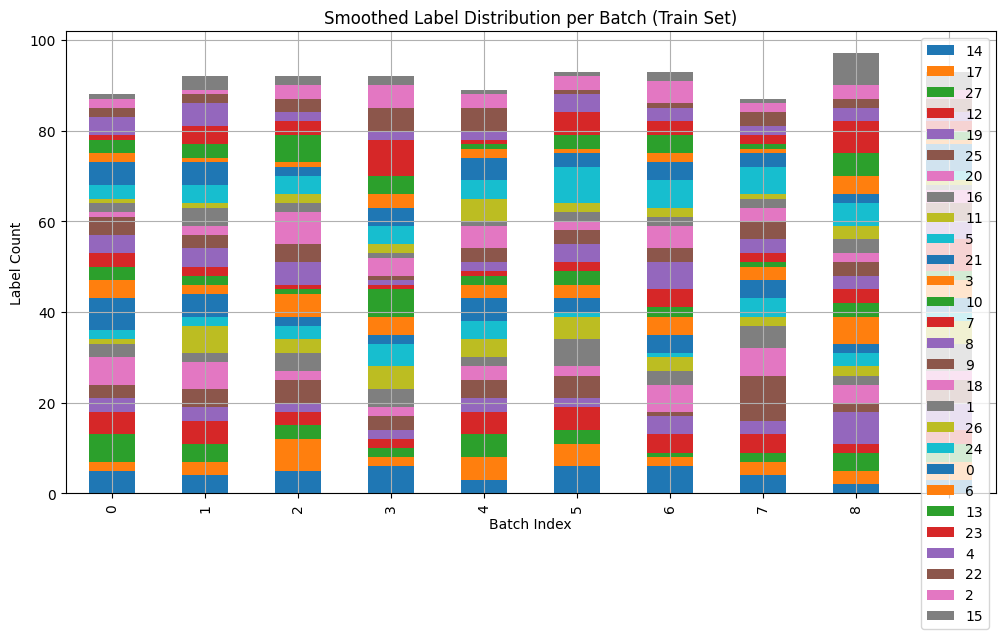

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(label_counts_per_batch).fillna(0).astype(int)
df.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.xlabel("Batch Index")
plt.ylabel("Label Count")
plt.title("Smoothed Label Distribution per Batch (Train Set)")
plt.grid(True)
plt.show()
